# Load and work with ang files for nice plots
### Takes .ang files, loads them, visualises as phase and IPF plots, generates plottable figures and more

### Need to install orix

In [1]:
#file finding and loading
import os, fnmatch


#orix imports
from orix import data, io, plot
from orix.crystal_map import CrystalMap, Phase, PhaseList
from orix.quaternion import Orientation, symmetry
from orix.vector import Vector3d, Miller, AxAngle
from orix.crystal_map import Phase
from orix.quaternion import Orientation, OrientationRegion, Rotation, Misorientation
from orix.quaternion.symmetry import C1, Oh

#standard imports
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.gridspec as gridspec
import matplotlib.patheffects as path_effects
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import numpy as np 
import pandas as pd

# Import scikit-learn DBSCAN
from sklearn.cluster import DBSCAN

# Colorisation & Animation
from skimage.color import label2rgb
from matplotlib.colors import to_rgb

In [2]:
#set up the Laue groups for plotting the IPF keys
pg_laue = [
    symmetry.Ci,
    symmetry.C2h,
    symmetry.D2h,
    symmetry.S6,
    symmetry.D3d,
    symmetry.C4h,
    symmetry.D4h,
    symmetry.C6h,
    symmetry.D6h,
    symmetry.Th,
    symmetry.Oh,
]
pg_HCP = pg_laue[8]
pg_BCC = pg_laue[10]

## Load and check data

In [3]:
### Load ang file, minor text fixing to ang files (correcting point group symmetry) 
# may be necessary to make them load correctly
filepath = '/local/scratch/EnriqueTitanium/2019_10_04_Ti_550/Scan5/'


In [4]:
paths = os.listdir(filepath)
files = []
for file in paths:
    if fnmatch.fnmatch(file, '*beta.ang'):
        files = files+[file]
files.sort()
print('Here is your file list:')
files

Here is your file list:


['Ti550_scan5_13_10_norot2_alphabeta.ang',
 'Ti550_scan5_13_10_norot2_beta.ang',
 'Ti550_scan5_13_10_norot3_beta.ang',
 'Ti550_scan5_13_10_norot_alphabeta.ang',
 'Ti550_scan5_13_10_norot_beta.ang',
 'Ti550_scan5_13_10_swap_alphabeta.ang',
 'Ti550_scan5_13_10_swap_beta.ang',
 'Ti550_scan5_rot_13_10_alphabeta.ang',
 'Ti550_scan5_rot_13_10_beta.ang',
 'Ti550_scan5_rot_13_10_flip_beta.ang',
 'Ti550_scan5_rot_13_10_rot90_alphabeta.ang',
 'Ti550_scan5_rot_13_10_rot90_beta.ang',
 'Ti550_scan5_rot_alphabeta.ang',
 'Ti550_scan5_rot_beta.ang',
 'Ti550_scan5_rot_v2_beta.ang',
 'Ti550_scan5_rot_v3_beta.ang']

In [5]:
file = files[1]
Timap = io.load(filepath+file)

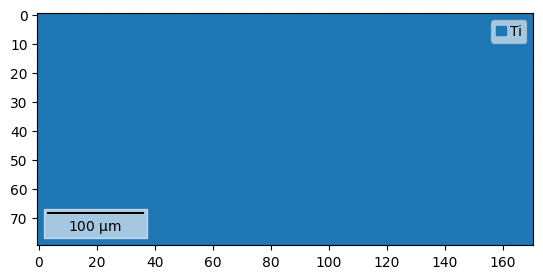

In [6]:
# Rough plot, only shows phases
Timap = Timap[:-20,20:]
Timap.plot()

In [7]:
# find width and height from ang file
width = int(Timap.x.max()/(Timap.x[1]-Timap.x[0]))
height = int(Timap.y.max()/(Timap.x[1]-Timap.x[0]))
print('Height =', height, 'pixels. Width =', width, 'pixels')

Height = 79 pixels. Width = 190 pixels


In [8]:
# Lists out the phase data
Timap.phases

Id  Name  Space group  Point group  Proper point group     Color
 1    Ti         None          432                 432  tab:blue

In [9]:
Timap

Phase    Orientations  Name  Space group  Point group  Proper point group     Color
    1  13680 (100.0%)    Ti         None          432                 432  tab:blue
Properties: iq, ci, detector_signal, fit
Scan unit: um

In [10]:
# Add correct space group information as not in .ang file
Timap.phases[1].space_group = 229
#Timap.phases[2].space_group = 229

In [11]:
# Just print various bits of info to check
print(Timap.phases.names)
print([i.short_name for i in Timap.phases.space_groups])
print([i.name for i in Timap.phases.point_groups])
print([i.proper_subgroup.name for i in Timap.phases.point_groups])
print(Timap.phases.colors)
print(Timap.phases.structures)

['Ti']
['Im-3m']
['m-3m']
['432']
['tab:blue']
[[]]


In [12]:
# Check for the Beta
Timap.phases["Ti"]
print(Timap.phases["Ti"].name)
print(Timap.phases["Ti"].space_group.short_name)
print(Timap.phases["Ti"].point_group.name)
print(Timap.phases["Ti"].point_group.proper_subgroup.name)
print(Timap.phases["Ti"].color)
print(Timap.phases["Ti"].structure)

Ti
Im-3m
m-3m
432
tab:blue
lattice=Lattice(a=3.232, b=3.232, c=3.232, alpha=90, beta=90, gamma=90)



## Plot IPFs

In [13]:
params = {
    'figure.figsize': (7, 7), 
    'font.size': 14,
    'axes.titlesize':20
}
plt.rcParams.update(params)

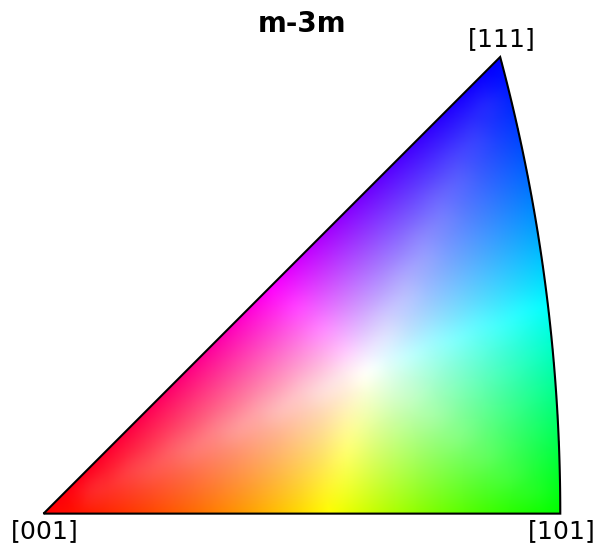

In [14]:
# Make the IPFkey and return a figure as a variable for use in next cell
plot.IPFColorKeyTSL(pg_BCC).plot()

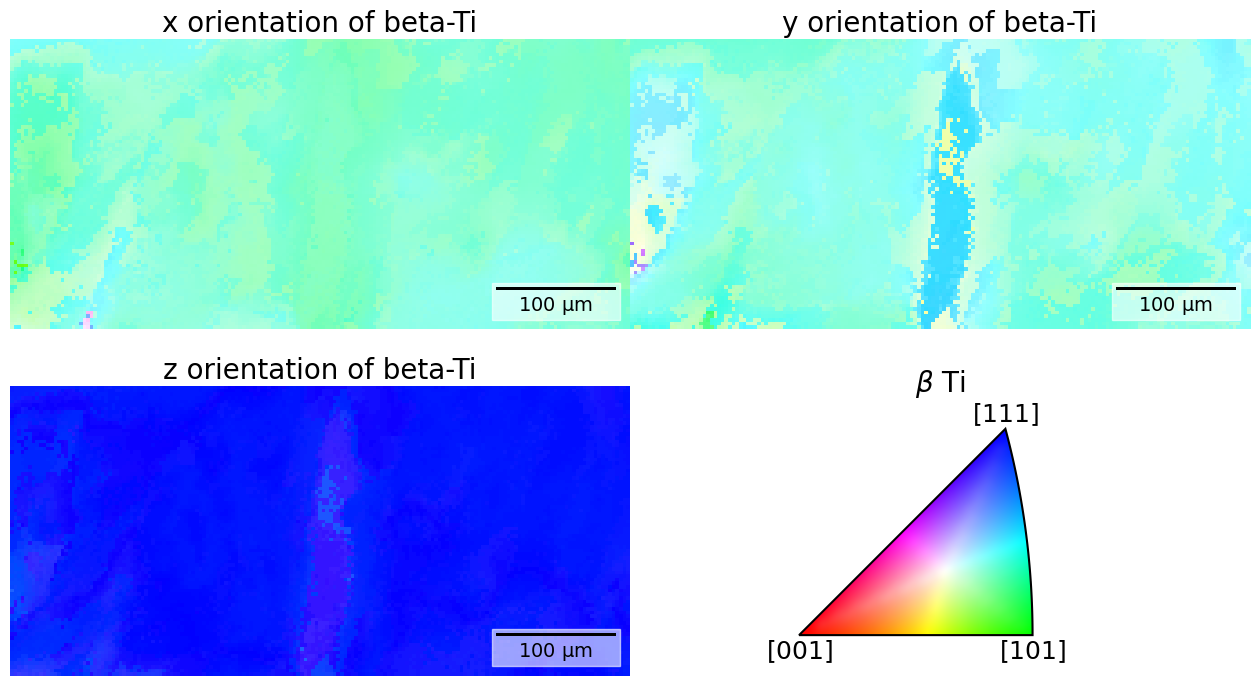

In [15]:
fig = plt.figure(figsize=(16,9))
gs = gridspec.GridSpec(2, 2, figure=fig, wspace=0, hspace=0)

ckey_622_x_BCC = plot.IPFColorKeyTSL(pg_BCC, direction=Vector3d.yvector())
ckey_622_y_BCC = plot.IPFColorKeyTSL(pg_BCC, direction=Vector3d.xvector())
ckey_622_z_BCC = plot.IPFColorKeyTSL(pg_BCC, direction=Vector3d.zvector())
rgb_beta_xyz = [ckey_622_x_BCC.orientation2color(Timap["Ti"].orientations),
                ckey_622_y_BCC.orientation2color(Timap["Ti"].orientations),
                ckey_622_z_BCC.orientation2color(Timap["Ti"].orientations)
               ]
labels = ['x','y','z']

for n in range(3):
    i = n%2
    j = int(np.floor(n/2))
    ax = plt.subplot(gs[j,i], projection="plot_map")
    ax.plot_map(Timap["Ti"], rgb_beta_xyz[n], 
                 scalebar_properties={"location": 4})
    ax.set_title(labels[n]+' orientation of beta-Ti', size = 20)
    ax.set_axis_off()
    
axb = plt.subplot(gs[1,1], projection='ipf', symmetry=pg_BCC)
axb.plot_ipf_color_key()
axb.set_xlim(-0.3,0.8)
axb.set_title(r'$\beta$ Ti',y=1.1)

fig.savefig('Figure S1.png', bbox_inches='tight')